In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties

file = './rhum.mon.mean.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['lon'],dataset.variables['lat']
time = dataset.variables['time']
level =dataset.variables['level']
rhum = dataset.variables['rhum']

cor_num = pd.read_excel(io = r'./ACEWP.xlsx')
coordinate = cor_num['WP'].tolist()


In [5]:
# num_month = time[:].data.shape[0] # 时间的size 从420开始
num_month_1982to1997 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数 
# 第二阶段从613开始到 900结束
# 因为列表从0开始计算，故第一阶段时间区间为[612, 899]
num_month_1998to2021 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数

# 选择level是700
def MeanYear(StartYear, EndYear):
    ls_mean_year = []
    for i in range(StartYear, EndYear, 12): 
        sum_month_year =  np.zeros(rhum[:1,3:4].data[0][:,:].shape, dtype=float, order='C')
        for month in range(12):
            tmp_month = i + month
            tmp_pre = rhum[tmp_month:tmp_month+1,3:4].data[0][:,:]
            sum_month_year += tmp_pre
        mean_year = sum_month_year / 12
    #     mean_year = mean_year.tolist()
        ls_mean_year.append(mean_year[0])

    ls_mean_year = np.array(ls_mean_year)
    reshape_mean = ls_mean_year.transpose(1,2,0)
    return reshape_mean

def num_month(a):
    '''
    计算循环的起始年，结束年
    '''
    if a == 1982:
        num_months = (1982 - 1948 + 1) * 12 
        num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
        start = num_months
        end = start + num_month_1997to1982
    elif a == 1998:
        start = (1998 - 1948 + 1) * 12 + 1
        num_month_2021to1998 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
        end = start + num_month_2021to1998
    else:
        print("Input must be 1982 or 1998!")
    return start, end

start_82, end_82 = num_month(1982)
start_98, end_98 = num_month(1998)

reshape_mean_1982to1997= MeanYear(start_82, end_82)
reshape_mean_1998to2021 = MeanYear(start_98, end_98)

In [22]:
def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((73,144), dtype=float, order='C')
    p_value = np.zeros((73,144), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 16:
                y = coordinate[:16]
            elif len(x) == 24:
                y = coordinate[16:]
            else:
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value

pearson_matrix_1997to1982, p_value_1997to1982 = PearsonMatrix(reshape_mean_1982to1997)
pearson_matrix_1998to2021, p_value_1998to2021 = PearsonMatrix(reshape_mean_1998to2021)

In [23]:
print(pearson_matrix_1997to1982.max(), pearson_matrix_1997to1982.min())
print(pearson_matrix_1998to2021.max(), pearson_matrix_1998to2021.min())

0.8010901230161906 -0.8824569108667049
0.756107177976351 -0.6453335400966751


In [16]:
latitude.shape

(73,)

In [42]:
p_value_1997to1982.shape

(73, 144)

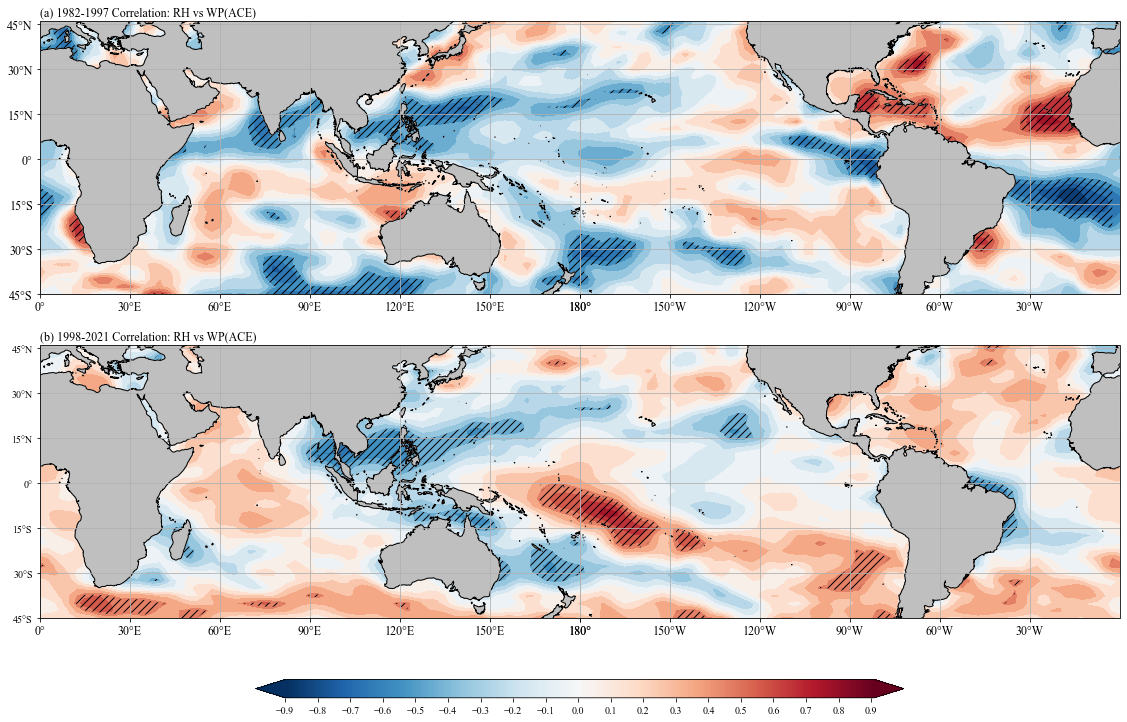

In [52]:
plt.rc('font',family='Times New Roman') 
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

data_1997to1982 = pearson_matrix_1997to1982 

# 调整经纬度 向东偏移180
new_data_1997to1982=[]
for i in range(data_1997to1982.shape[0]):
    tmp = np.append(data_1997to1982[i], data_1997to1982[i][0])
    new_data_1997to1982.append(tmp.tolist())

#设置填色图投影方式，以及地图边界
proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181.1, -45, 46)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
#建立画布
fig = plt.figure(figsize=(15,15))
# 添加第一个子图
fig_ax1 = fig.add_axes([0, 0.3, 1, 1], projection = proj)

fig_ax1.contourf(longitude[:].data, lat, p_value_1997to1982,
            [np.nanmin(p_value_1997to1982), 0.05, np.nanmax(p_value_1997to1982)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1982-1997 Correlation: RH vs WP(ACE)',loc='left',fontsize =12)

cont_ax1 = fig_ax1.contourf(lon, lat, new_data_1997to1982, 
                 levels=np.arange(-0.90, 0.91, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

# ====================子图2======================
# 调整经纬度 向东偏移180
data_1998to2021 = pearson_matrix_1998to2021
# 调整经纬度 向东偏移180
new_data_1997to1982=[]
for i in range(data_1998to2021.shape[0]):
    tmp = np.append(data_1998to2021[i], data_1998to2021[i][0])
    new_data_1997to1982.append(tmp.tolist())

fig_ax2 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax2.contourf(longitude[:].data, lat, p_value_1998to2021,
            [np.nanmin(p_value_1998to2021), 0.05, np.nanmax(p_value_1998to2021)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 1998-2021 Correlation: RH vs WP(ACE)',loc='left',fontsize =12)
cont_ax2 = fig_ax2.contourf(lon, lat, new_data_1997to1982, 
                 levels=np.arange(-0.90, 0.91, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }

norm = colors.Normalize(vmin=-0.90, vmax=0.91)    #确定colormap的最大最小值

# position = fig.add_axes([0.2, 0.68, 0.6, 0.017]) #中间位置
position = fig.add_axes([0.2, 0.3, 0.6, 0.017]) # 最下面位置

fc2=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 cax=position,
                 orientation='horizontal',
                 ticks=np.arange(-0.90, 0.91, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 

fc2.set_label(label="", fontdict=font) #设置colorbar的标签字体及其大小


plt.savefig("rhum_correl_2phase.png",dpi=300,bbox_inches='tight')

plt.show()